# 11-experiment-three-cogsci

## Analysis

In [22]:
# Analytical Tools
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Import Data & Define Constants

In [23]:
GROUPS = 2
QUESTIONS = 5
JUDGMENTS = 6
SCORE_THRESHOLD = 240.9

data = pd.read_pickle('data/responses.pkl')
data.head()

,id,consent,attention,g0_q0_score,g0_q0_index,g0_q0_j0,g0_q0_j1,g0_q0_j2,g0_q0_j3,g0_q0_j4,...,g1_q4_score,g1_q4_index,g1_q4_j0,g1_q4_j1,g1_q4_j2,g1_q4_j3,g1_q4_j4,g1_q4_j5,j_mean,j_std
0,sana26r21r9md90gqj3o7fm1rm4rpw2p,1,1,36,2,4,3,5,0,5,...,24039,40,3,2,4,5,1,5,3.083333,1.649773
1,68d2brqo4tuf7kstwx0evwcuu5hqf9o2,1,1,30,10,2,2,3,2,2,...,24051,0,1,3,1,1,1,1,2.033333,0.973665
2,rxt9ompoqypdk5v67wmwpseu29te3s08,1,1,14,32,6,2,5,2,3,...,24047,23,2,0,1,6,6,1,3.366667,2.041657
4,wul66ydj8kvrksvrb3u57s0eap457scs,1,1,24,41,5,0,3,4,6,...,24032,42,2,0,4,6,5,4,2.533333,2.417918
5,3lmswywcgo03yave2grh38pyqagaxjqo,1,1,26,20,6,1,3,1,5,...,24052,0,3,0,3,2,1,3,3.066667,2.024148


### Analysis

In [24]:
for g_num in range(GROUPS):
    for j_num in range(JUDGMENTS):
        headings = []
        for q_num in range(QUESTIONS):
            headings.append('g{}_q{}_j{}'.format(g_num, q_num, j_num))
        
        rating_mean = data[headings].mean(axis=1)
        data['g{}_j{}_mean'.format(g_num, j_num)] = rating_mean

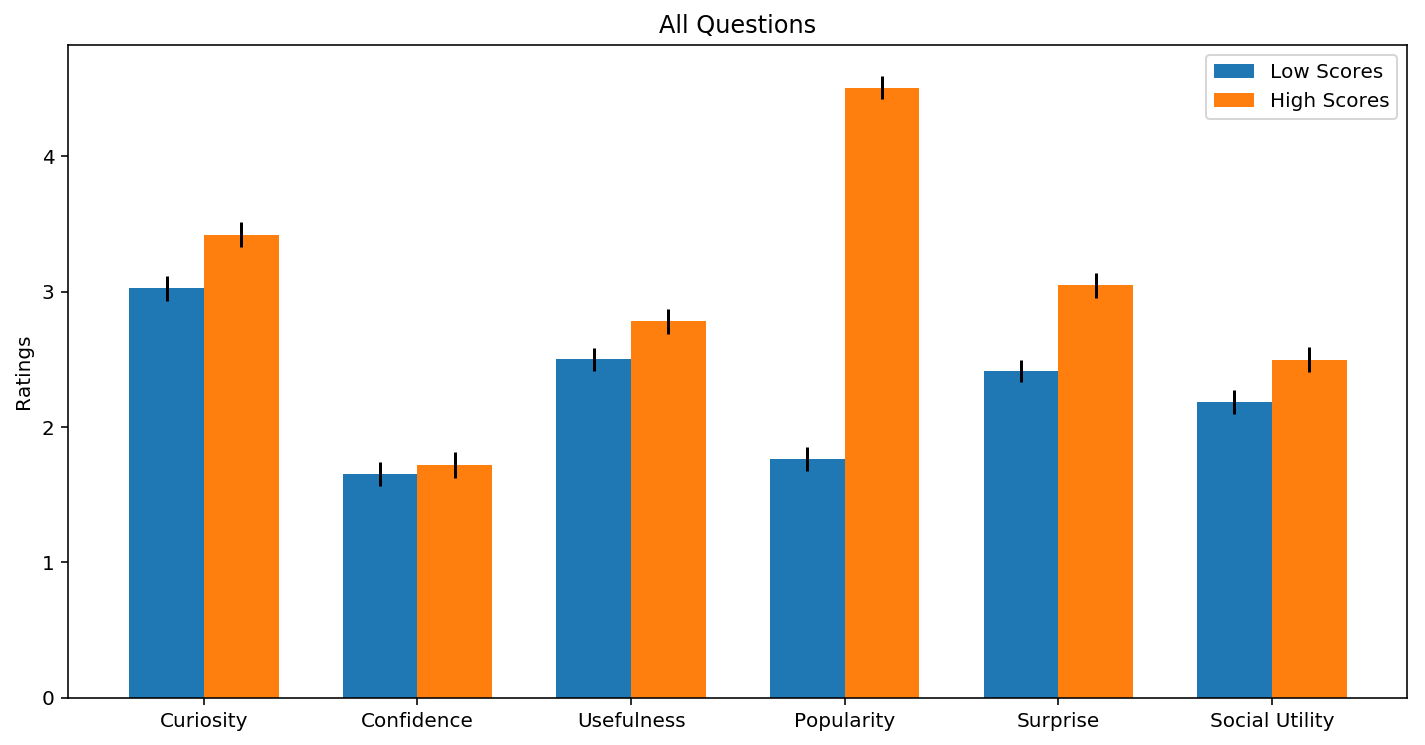

[3.0230769230769234, 1.6509615384615388, 2.4990384615384613, 1.7605769230769224, 2.411538461538462, 2.184615384615385]
[3.420192307692306, 1.718269230769231, 2.7788461538461537, 4.506730769230769, 3.046153846153844, 2.496153846153846]


In [25]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Surprise', 'Social Utility'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

# for _ in range(1):
#     sample = data.iloc[random.sample(range(len(data)), len(data))]
    
sample = data

g0_means, g0_errs = [], []
g1_means, g1_errs = [], []
for j_num in range(JUDGMENTS):
    g0_values = sample['g0_j{}_mean'.format(j_num)]
    g1_values = sample['g1_j{}_mean'.format(j_num)]
    g0_means.append(g0_values.mean())
    g1_means.append(g1_values.mean())
    g0_errs.append(stats.sem(g0_values))
    g1_errs.append(stats.sem(g1_values))

plotting.plot_double_bar(
    g0_means, g0_errs, g1_means, g1_errs, 
    **PLOTTING_OPTIONS
)

print(g0_means)
print(g1_means)

In [26]:
print('Low & High')
for j_num in range(JUDGMENTS):
    g0_values = data['g0_j{}_mean'.format(j_num)]
    g2_values = data['g1_j{}_mean'.format(j_num)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][j_num],
                          describe.paired_t_test(g0_values, g2_values)))

Low & High
Curiosity: t = -4.93, p = 1.65e-06, Δ = 0.397 (1 greater)
Confidence: t = -1.04, p = 0.301, Δ = 0.0673 (1 greater)
Usefulness: t = -3.75, p = 0.000234, Δ = 0.28 (1 greater)
Popularity: t = -19.9, p = 5.71e-50, Δ = 2.75 (1 greater)
Surprise: t = -5.74, p = 3.39e-08, Δ = 0.635 (1 greater)
Social Utility: t = -4.52, p = 1.06e-05, Δ = 0.312 (1 greater)


In [27]:
g0_confidences = {num: [] for num in range(7)}
g1_confidences = {num: [] for num in range(7)}
for index, row in data.iterrows():
    for q_num in range(QUESTIONS):
        cur_rating = row['g0_q{}_j0'.format(q_num)]
        conf_rating = row['g0_q{}_j1'.format(q_num)]
        g0_confidences[conf_rating].append(cur_rating)
        
        cur_rating = row['g1_q{}_j0'.format(q_num)]
        conf_rating = row['g1_q{}_j1'.format(q_num)]
        g1_confidences[conf_rating].append(cur_rating)
        
all_confidences = {}
for num in range(7):
    all_confidences[num] = g0_confidences[num] + g1_confidences[num]

Low


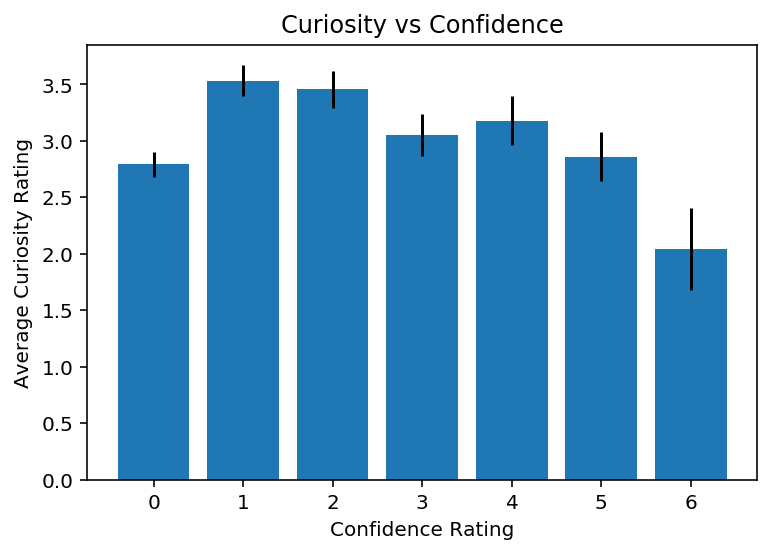

High


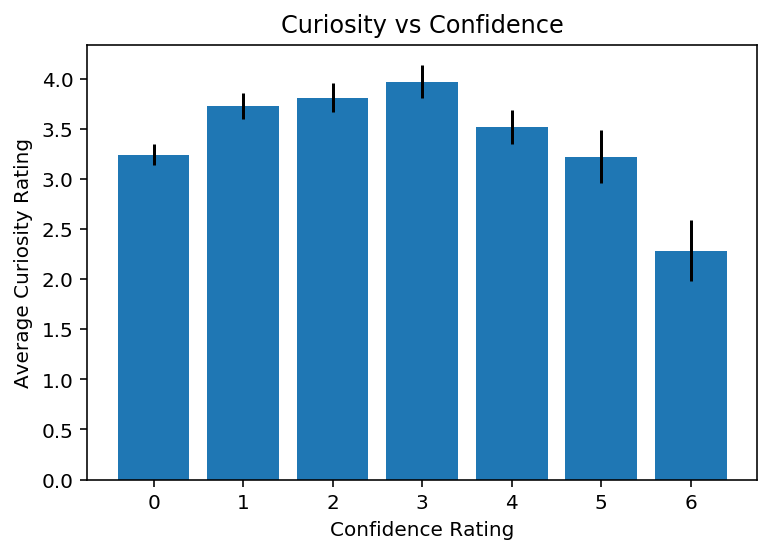

Both


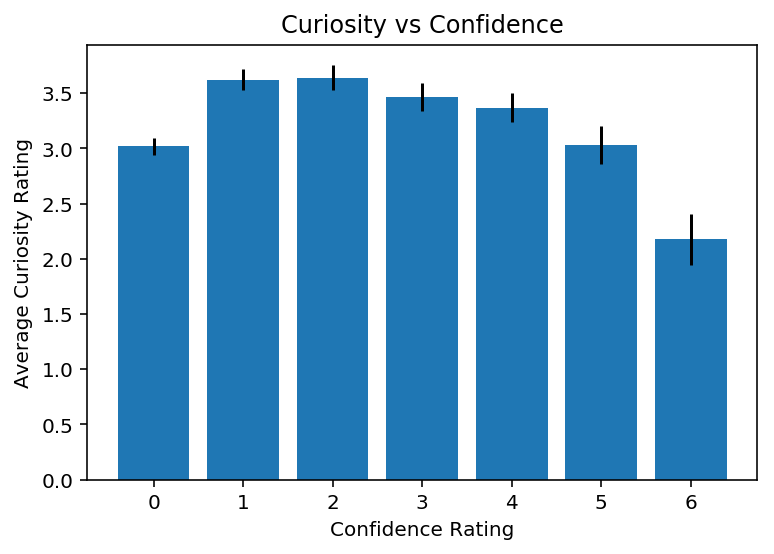

In [29]:
PLOTTING_OPTIONS = {
    'ylabel': 'Average Curiosity Rating',
    'xlabel': 'Confidence Rating',
    'title': 'Curiosity vs Confidence',
}
PLOTS = ['Low', 'High', 'Both']

for dataset, name in zip((g0_confidences, g1_confidences, all_confidences), PLOTS):
    print(name)
    means = [np.mean(dataset[num]) for num in range(7)]
    stderr = [stats.sem(dataset[num]) for num in range(7)]
    
    plotting.plot_single_bar(
        means, stderr,
        **PLOTTING_OPTIONS
    )
plt.show()

# plt.title('Curiosity vs Confidence: All')
# plt.scatter(
#     g0_confidences + g1_confidences,
#     g0_curiosities + g1_curiosities
# )
# plt.show()

# plt.title('Curiosity vs Confidence: Low')
# plt.scatter(g0_confidences, g0_curiosities)
# plt.show()

# plt.title('Curiosity vs Confidence: High')
# plt.scatter(g1_confidences, g1_curiosities)
# plt.show()